In [7]:
! pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from scipy import stats
from statsmodels.tools.eval_measures import rmse

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df = pd.read_csv("/content/drive/MyDrive/Fall 2021 DSCI560/meeting1/all_level.txt") 

In [11]:
level1 = df[df['location']=="1st Floor"].reset_index()
level2 = df[df['location']=="2nd Floor"].reset_index()
level3 = df[df['location']=="3rd Floor"].reset_index()
levelg = df[df['location']=="Ground Floor"].reset_index()

In [12]:
# https://www.kaggle.com/wuxt830/electricity-usage-prediction-simple-time-series#2.-Seasonal-ARIMA-Model 
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=20).mean()
    rolstd = timeseries.rolling(window=20).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# ---------------------------------------------------------------------

In [16]:
train_g, test_g = train_test_split(levelg['count'].dropna(inplace=False), train_size=320)
model_g = pm.auto_arima(train_g, seasonal=True, stepwise=True)

In [17]:
model_g.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -4016.446
Date:                Tue, 23 Nov 2021   AIC                           8052.893
Time:                        23:28:51   BIC                           8090.545
Sample:                             0   HQIC                          8067.930
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4604      0.097      4.730      0.000       0.270       0.651
ar.L2         -1.1680      0.070    -16.786      0.000      -1.304      -1.032
ar.L3          0.3479      0.123      2.818      0.005       0.106       0.590
ar.L4         -0.6732      0.074     -9.087      0.000      -0.818      -0.528
ar.L5         -0.2761      0.071     -3.894      0.000      -0.415      -0.137
ma.L1         -0.7383      0.092     -8.026      0.000      -0.919      -0.558
ma.L2          0.9780      0.085     11.551      0.000       0.812       1.144
ma.L3         -0.7999      0.070    -11.443      0.000      -0.937      -0.663
ma.L4          0.4666      0.078      6.001      0.000       0.314       0.619
sigma2      5.738e+09   3.44e-12   1.67e+21      0.000    5.74e+09    5.74e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               428.53
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+37. Standard errors may be unstable.
"""

In [18]:
pred_model_g = SARIMAX(train_g, order=(5,1,0),  trend='c',seasonal_order=(1,1,1,7))
results_g = pred_model_g.fit()

In [19]:
test_pred_g = test_g.copy()
test_pred_g = results_g.predict(start = len(train_g), end = len(levelg)-1, typ="levels")  

In [20]:
future_pred_g = results_g.predict(start = len(train_g), end = len(levelg)+19,typ="levels")

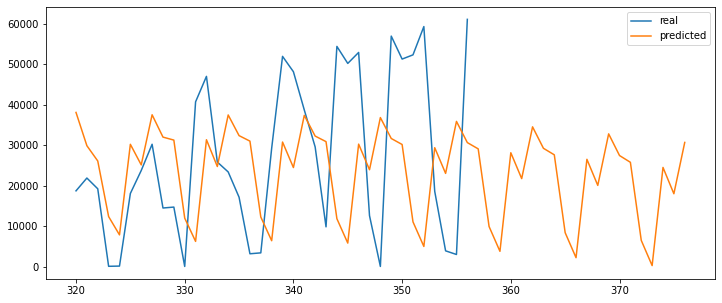

In [21]:
test_g.plot(figsize = (12,5), label='real')
#test_pred_g.plot(label = 'predicted')
future_pred_g.plot(label = 'predicted')
#future_pred_g.plot(label = 'future')
plt.legend(loc='upper right')

In [22]:
arima_rmse_error = rmse(test_g, test_pred_g[36:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 403802066.40046334
RMSE Error: 20094.826856692827


<Figure size 432x288 with 0 Axes>

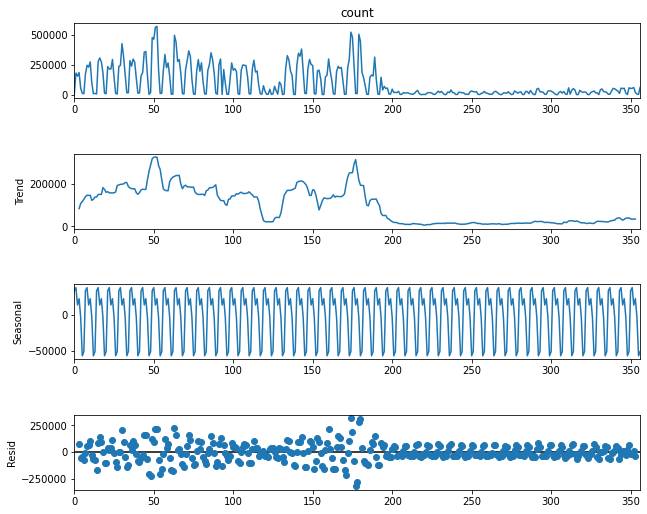

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_g = seasonal_decompose(levelg['count'], period=7)
fig = plt.figure()  
fig = decomposed_g.plot()  
fig.set_size_inches(10, 8)

In [92]:
trend_g = decomposed_g.trend
seasonal_g = decomposed_g.seasonal 
residual_g = decomposed_g.resid

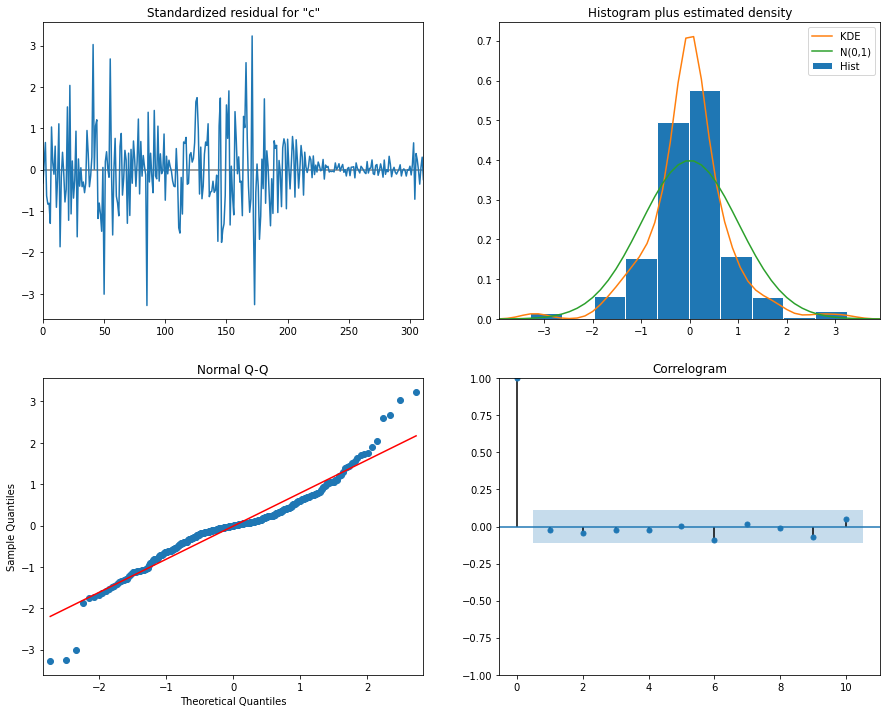

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults 
results_g.plot_diagnostics(figsize=(15, 12))

plt.show()
#print("Ljung-box p-values:\n" + str(results_g.test_serial_correlation(method='ljungbox')[0][1]))


In [23]:
train_ = pd.DataFrame(round(train_g))
test_pred_g = pd.DataFrame(round(test_pred_g))
test_pred_g.rename({'predicted_mean': 'count'}, axis=1,inplace=True)

In [24]:
output_g = pd.concat([train_, test_pred_g])
output_g2 = pd.concat([levelg['date'],output_g], axis=1)
output_g_with_true = pd.concat([output_g2, levelg['count']], axis = 1)
output_g_with_true.columns = ['date', 'prediction','true']

In [25]:
output_g_with_true.to_csv('prediction_g.csv', header=True, index=False, sep=',')

In [26]:
future_g = pd.DataFrame(round(future_pred_g)).tail(20)
future_g.to_csv('future_g.txt', header=True, index=False, sep=',')

# 1st Floor---------------------------------------------------------------------

In [27]:
level1.sort_index(inplace= True)

In [28]:
from scipy import stats
level1['box_cox_count'] = stats.boxcox(level1['count'])[0]

In [29]:
train, test = train_test_split(level1['count'].dropna(inplace=False), train_size=320)
model = pm.auto_arima(train, seasonal=True, stepwise=True)

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -4075.672
Date:                Tue, 23 Nov 2021   AIC                           8163.343
Time:                        23:29:00   BIC                           8185.934
Sample:                             0   HQIC                          8172.365
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1993      0.025     48.832      0.000       1.151       1.247
ar.L2         -0.9290      0.022    -42.532      0.000      -0.972      -0.886
ma.L1         -1.5856      0.047    -33.409      0.000      -1.679      -1.493
ma.L2          1.0629      0.077     13.851      0.000       0.913       1.213
ma.L3         -0.2487      0.051     -4.913      0.000      -0.348      -0.149
sigma2      8.311e+09      2e-12   4.15e+21      0.000    8.31e+09    8.31e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               176.29
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+37. Standard errors may be unstable.
"""

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
pred_model = SARIMAX(train, order=(2,1,3), seasonal_order=(0,1,1,7))
results = pred_model.fit()

In [32]:
test_pred=test.copy()
test_pred = results.predict(start = len(train), end = len(level1)-1, typ="levels")  

In [33]:
future_pred = results.predict(start = len(train), end = len(level1)+19,typ="levels")

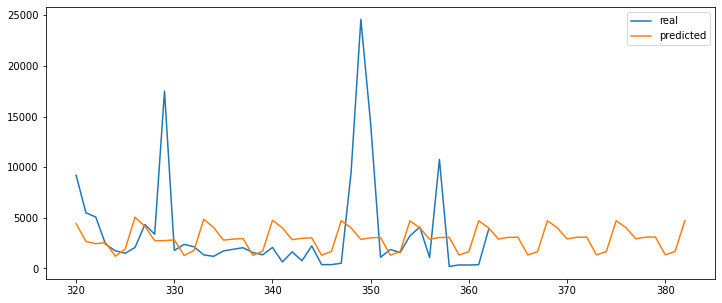

In [34]:
test.plot(figsize = (12,5), label='real')
future_pred.plot(label = 'predicted')
plt.legend(loc='upper right')

In [35]:
from statsmodels.tools.eval_measures import rmse
arima_rmse_error = rmse(test, test_pred[42:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 24272769.69269459
RMSE Error: 4926.740270472414


In [69]:
stl = STL(ts2017,seasonal=7,robust=True)
res = stl.fit()
fig = res.plot()

NameError: ignored

In [68]:
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

NameError: ignored

In [36]:
train1 = pd.DataFrame(round(train))
test_pred_1 = pd.DataFrame(round(test_pred))
test_pred_1.rename({'predicted_mean': 'count'}, axis=1,inplace=True)

In [37]:
output_1 = pd.concat([train1, test_pred_1])
output_12 = pd.concat([level1['date'], output_1], axis=1)
output_1_with_true = pd.concat([output_12, level1['count']], axis = 1)
output_1_with_true.columns = ['date', 'prediction','true']
output_1_with_true

,date,prediction,true
0,2019-08-12,1721.0,1721
1,2019-08-13,321436.0,321436
2,2019-08-14,240043.0,240043
3,2019-08-15,173298.0,173298
4,2019-08-16,137361.0,137361
...,...,...,...
358,2020-08-28,3076.0,198
359,2020-08-29,1325.0,347
360,2020-08-30,1656.0,335
361,2020-08-31,4705.0,372


In [38]:
output_1_with_true.to_csv('prediction_1.csv', header=True, index=False, sep=',')

In [39]:
future= pd.DataFrame(round(future_pred)).tail(20)
future.to_csv('future.txt', header=True, index=False, sep=',')

# 2nd Floor --------------------------------------------------------------------------

In [40]:
level2['box_cox_count'] = stats.boxcox(level2['count'])[0]

In [41]:
level2['first_difference'] = level2['box_cox_count'] - level2['box_cox_count'].shift(1)   

In [42]:
train_2, test_2 = train_test_split(level2['count'].dropna(inplace=False), train_size=320)
model_2 = pm.auto_arima(train_2, seasonal=True, stepwise=True)

In [43]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -4109.260
Date:                Tue, 23 Nov 2021   AIC                           8238.521
Time:                        23:29:18   BIC                           8276.172
Sample:                             0   HQIC                          8253.557
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4655      0.147      3.157      0.002       0.177       0.755
ar.L2         -1.1357      0.099    -11.435      0.000      -1.330      -0.941
ar.L3          0.3257      0.183      1.782      0.075      -0.033       0.684
ar.L4         -0.6575      0.091     -7.191      0.000      -0.837      -0.478
ar.L5         -0.2514      0.104     -2.420      0.016      -0.455      -0.048
ma.L1         -0.8537      0.134     -6.381      0.000      -1.116      -0.592
ma.L2          0.9764      0.134      7.278      0.000       0.713       1.239
ma.L3         -0.7821      0.125     -6.261      0.000      -1.027      -0.537
ma.L4          0.3727      0.114      3.275      0.001       0.150       0.596
sigma2      1.008e+10   5.84e-11   1.73e+20      0.000    1.01e+10    1.01e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               369.47
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.22e+35. Standard errors may be unstable.
"""

In [44]:
pred_model_2 = SARIMAX(train_2, order=(5,2,4), seasonal_order=(1,1,1,7))
results_2 = pred_model_2.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [45]:
test_pred_2 = test_2.copy()
test_pred_2 = results_2.predict(start = len(train_2), end = len(level2)-1, typ="levels")  

In [46]:
future_pred_2= results_g.predict(start = len(train_2), end = len(train_2)+19,typ="levels")

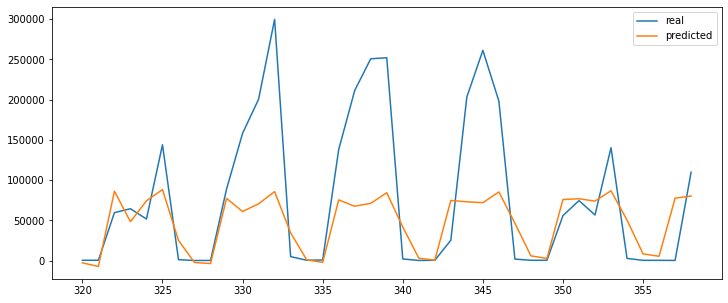

In [47]:
test_2.plot(figsize = (12,5), label='real')
test_pred_2.plot(label = 'predicted')
plt.legend(loc='upper right')

In [48]:
arima_rmse_error = rmse(test_2, test_pred_2[38:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 8638271930.336224
RMSE Error: 92942.30430937369


In [49]:
train_2 = pd.DataFrame(round(train_2))
test_pred_2 = pd.DataFrame(round(test_pred_2))
test_pred_2.rename({'predicted_mean': 'count'}, axis=1,inplace=True)

In [50]:
test_pred_2.loc[test_pred_2['count']<0, 'count'] = 0

In [51]:
output_2 = pd.concat([train_2, test_pred_2])
output_22 = pd.concat([level2['date'], output_2], axis=1)
output_2_with_true = pd.concat([output_22, level2['count']], axis = 1)
output_2_with_true.columns = ['date', 'prediction','true']
output_2_with_true

,date,prediction,true
0,2019-08-12,1057.0,1057
1,2019-08-13,385620.0,385620
2,2019-08-14,335570.0,335570
3,2019-08-15,367981.0,367981
4,2019-08-16,173529.0,173529
...,...,...,...
354,2020-08-28,50486.0,2802
355,2020-08-29,8396.0,457
356,2020-08-30,5481.0,457
357,2020-08-31,77657.0,325


In [52]:
output_2_with_true.to_csv('prediction_2.csv', header=True, index=False, sep=',')

In [53]:
future2= pd.DataFrame(round(future_pred_2)).tail(20)
future2.to_csv('future2.txt', header=True, index=False, sep=',')

# 3rd floor-------------------------------------------------


In [54]:
level3['box_cox_count'] = stats.boxcox(level3['count'])[0]

In [55]:
level3['first_difference'] = level3['box_cox_count'] - level3['box_cox_count'].shift(1)   

In [56]:
train_3, test_3 = train_test_split(level3['count'].dropna(inplace=False), train_size=260)
model_3 = pm.auto_arima(train_3, seasonal=True, stepwise=True)

In [57]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  260
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -2897.816
Date:                Tue, 23 Nov 2021   AIC                           5811.632
Time:                        23:29:36   BIC                           5840.087
Sample:                             0   HQIC                          5823.073
                                - 260                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9144      0.132      6.903      0.000       0.655       1.174
ar.L2         -1.0501      0.117     -8.990      0.000      -1.279      -0.821
ar.L3          0.1767      0.097      1.829      0.067      -0.013       0.366
ar.L4         -0.2287      0.080     -2.857      0.004      -0.386      -0.072
ma.L1         -1.3439      0.134    -10.049      0.000      -1.606      -1.082
ma.L2          1.1441      0.154      7.444      0.000       0.843       1.445
ma.L3         -0.5316      0.098     -5.397      0.000      -0.725      -0.339
sigma2      3.194e+08   3.31e-10   9.64e+17      0.000    3.19e+08    3.19e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.35
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.52e+33. Standard errors may be unstable.
"""

In [58]:
pred_model_3 = SARIMAX(train_3, order=(4,1,3), seasonal_order=(3,1,0,7))
results_3 = pred_model_3.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [59]:
test_pred_3 = test_3.copy()
test_pred_3 = results_3.predict(start = len(train_3), end = len(level3)-1, typ="levels")

In [60]:
future_pred_3= results_g.predict(start = len(train_3), end = len(level3)+19,typ="levels")

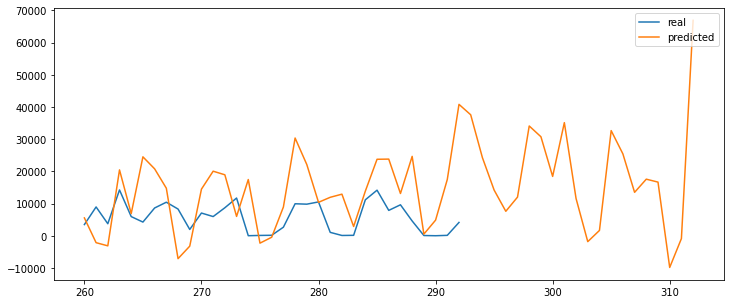

In [61]:
test_3.plot(figsize = (12,5), label='real')
future_pred_3.plot(label = 'predicted')
plt.legend(loc='upper right')

In [62]:
arima_rmse_error = rmse(test_3, test_pred_3[32:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 46366028.31561631
RMSE Error: 6809.260482285599


In [63]:
train_3 = pd.DataFrame(round(train_3))
test_pred_3 = pd.DataFrame(round(test_pred_3))
test_pred_3.rename({'predicted_mean': 'count'}, axis=1,inplace=True)

In [64]:
test_pred_3.loc[test_pred_3['count']<0, 'count'] = 0

In [65]:
output_3 = pd.concat([train_3, test_pred_3])
output_32 = pd.concat([level3['date'], output_3], axis=1)
output_3_with_true = pd.concat([output_32, level3['count']], axis = 1)
output_3_with_true.columns = ['date', 'prediction','true']
output_3_with_true

,date,prediction,true
0,2019-08-13,57762.0,57762
1,2019-08-14,52257.0,52257
2,2019-08-15,51650.0,51650
3,2019-08-16,26411.0,26411
4,2019-08-17,1548.0,1548
...,...,...,...
288,2020-08-28,0.0,4634
289,2020-08-29,0.0,116
290,2020-08-30,629.0,52
291,2020-08-31,0.0,167


In [66]:
output_3_with_true.to_csv('prediction_3.csv', header=True, index=False, sep=',')

In [67]:
future3= pd.DataFrame(round(future_pred_3)).tail(20)
future3.loc[future3['predicted_mean']<0, 'predicted_mean'] = 0
future3.to_csv('future3.txt', header=True, index=False, sep=',')